# Problem statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we will analyze customer-level data of a telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.


# todo EDA:
- total charges depending on tenure? is it leaking?
- Better visualisation for all feature distributions

In [27]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Import custom functions from utils file
from utils import *

# Set display options for data exploratory analysis
pd.set_option('display.max_columns', None)


In [28]:
# Read data
df = pd.read_csv('churn_initial_df.csv')

# Data cleansing & Outlier detection
In this section, we will cover the topic of outliers and data cleansing, as well as inspecting missing values. Outliers are data points that deviate significantly from the rest of the data and can skew analysis, while missing values can introduce bias and inaccuracies in data analysis. We will explore different methods for identifying and handling outliers and missing values, including replacing missing values and clamping outliers. These techniques will help to ensure that our data is clean and reliable for further analysis.

In [29]:
# Inspect the columns, potential null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [30]:
# Print all unique values for each column.
#   This will help us inspect strange values in columns.
for column in df.columns:
    unique_values = df[column].unique()
    print(f"{column}: {unique_values}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)

### Correct values in column
If the column is not properly classified as boolean, it can affect the performance of certain models or analyses that require boolean data. Additionally, it may be misleading to interpret non-boolean columns as boolean, which can lead to incorrect conclusions or actions based on the data.

In [31]:
# There are some columns that are supposed to have categorical values only,
#   but include more. We need to correct them.

# replace 'No phone service' with NaN values
df['MultipleLines'].replace('No phone service', np.nan, inplace=True)

# replace 'No internet service' with NaN values
df.replace('No internet service', np.nan, inplace=True)

# create a new column 'Has_Internet_Service' which has a value of 1 if any of the columns in a row have a non-NaN value
df['Has_Internet_Service'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].notnull().any(axis=1).astype(int)

# replace 'Yes' with 1 and 'No' with 0
df.replace(['Yes', 'No'], [1, 0], inplace=True)

# fill NaN values with 0s for the new columns
df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']].fillna(0).astype('int64')


# Replace Yes, No with 1,0 in all columns where there is
#    only Yes, No values

# Loop through each column
for col in df.columns:
    # Check if column has only 'Yes' and 'No' values
    if set(df[col].unique()) == set(['Yes', 'No']):
        # Replace 'Yes' with 1 and 'No' with 0
        df[col] = df[col].map({'Yes': 1, 'No': 0})


# Define list of columns to convert to numeric
cols_to_convert = ['TotalCharges']

# Loop through each column and convert to float
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert categorical variables to binary using one-hot encoding
#    The resulting dummy variables are added to the DataFrame as new columns
df = pd.get_dummies(df, columns=["gender", "Contract", "InternetService", "PaymentMethod"])

# Drop the column because it is redundant with Has_Internet_Service column
df.drop('InternetService_0', axis=1, inplace=True)

# Print data types of all columns
print(df.dtypes)

customerID                                  object
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
Has_Internet_Service                         int64
gender_Female                                uint8
gender_Male                    

### Identify duplicates
Duplicate rows can skew summary statistics, such as means and standard deviations, and create biases in machine learning models. They can also cause data redundancy and increase the computational time required to process the data. Therefore, identifying and removing duplicates can improve the quality and reliability of the data used for analysis and modeling.

In [32]:
# Apply function
check_for_duplicates(df)

- There are no duplicated values in the dataframe.


### Missing values
If there are missing values in a dataset, it can impact the statistical power of your analysis, and can even result in incorrect conclusions. Furthermore, many machine learning algorithms require complete data, and missing values can cause errors in these algorithms. Therefore, it is essential to identify and handle missing data appropriately.

In [33]:
# Apply function
check_for_missing_values(df)

- There are missing values in the dataframe. Column 'TotalCharges' has missing values.


In [34]:
# Based on the previous output, there are missing values in the column 'TotalCharges'
#    Therefore, we have to replace NaN values in TotalCharges with 0s
df['TotalCharges'] = df['TotalCharges'].fillna(0).astype('int64')


### Imbalanced dataset
If a dataset is imbalanced, meaning that one class of the target variable is overrepresented compared to the other, the model may learn to predict the majority class more accurately and perform poorly on the minority class. This can result in biased or inaccurate predictions, especially if the minority class is of particular interest. By identifying and addressing class imbalance, such as through resampling techniques or adjusting class weights, a model can be trained to better handle imbalanced data and make more accurate predictions.


In [35]:
# Apply function
check_for_imbalanced_dataset(df)

- The dataframe is imbalanced, with an imbalance ratio of 0.27.



### Outliers
Flagging outliers in a dataset can be useful in identifying potential errors or anomalies in the data, Additionally, you can use the flags as a feature in your model to improve its accuracy, or use them to create new features that capture the presence of outliers in the data. In this function, outliers are detected by comparing each value to the mean and standard deviation of the column, as well as the 1st and 99th percentiles of the column. The function skips outlier detection for binary columns, and joins the outlier flags DataFrame with the input DataFrame to return a new DataFrame with outlier flags. This function can be useful for identifying and handling outliers before training a model.


In [36]:
# Apply function
df = flag_outliers(df)

Outlier column created: tenure
Outlier column created: MonthlyCharges
Outlier column created: TotalCharges


### Clamp outliers
Clamping outliers in numerical columns can help to improve the overall quality of the data and prevent the model from being biased by the presence of extreme values. By replacing outliers with the nearest in-range values, the distribution of the data becomes more normalized, which can help the model make more accurate predictions. Clamping outliers also helps to avoid the risk of overfitting to the training data, which can happen when the model is trying to learn from extreme and non-representative values.

In [37]:
# Apply function
df = clamp_outliers(df)

Columns to be modified: 
tenure
MonthlyCharges
TotalCharges

86 customer IDs affected.


### Optional
It is generally a good practice to scale or normalize your data before using it for model training with XGBoost. The main reason for doing this is to ensure that all features contribute equally to the model and to avoid the domination of certain features over others.

For example, if you do not scale or normalize the TotalCharges feature, it may dominate over other features that have smaller values, causing the model to become biased towards it. By scaling or normalizing the features, you can bring them to the same scale and make them equally important for the model.

Therefore, it is recommended to scale or normalize your data before using it for model training with XGBoost. There are several methods for scaling or normalization, including StandardScaler, MinMaxScaler, and RobustScaler. You can choose the one that best suits your data and the specific problem you are trying to solve.

In [38]:
# # Define the columns to normalize
# # cols_to_normalize = ['MonthlyCharges', 'TotalCharges']
# cols_to_normalize = ['tenure', 'MonthlyCharges', 'TotalCharges']

# # Create the MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit and transform the data
# df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# # Check how the column values look after the normalization
# df[cols_to_normalize].head()


In [39]:
df

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Has_Internet_Service,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_outlier,MonthlyCharges_outlier,TotalCharges_outlier
0,7590-VHVEG,0,1,0,1.0,0,0,0,1,0,0,0,0,1,29.85,29.0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0
1,5575-GNVDE,0,0,0,34.0,1,0,1,0,1,0,0,0,0,56.95,1889.0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0
2,3668-QPYBK,0,0,0,2.0,1,0,1,1,0,0,0,0,1,53.85,108.0,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0
3,7795-CFOCW,0,0,0,45.0,0,0,1,0,1,1,0,0,0,42.30,1840.0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0
4,9237-HQITU,0,0,0,2.0,1,0,0,0,0,0,0,0,1,70.70,151.0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,1,1,24.0,1,1,1,0,1,1,1,1,1,84.80,1990.0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0
7039,2234-XADUH,0,1,1,72.0,1,1,0,1,1,0,1,1,1,103.20,7362.0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0
7040,4801-JZAZL,0,1,1,11.0,0,0,1,0,0,0,0,0,1,29.60,346.0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0
7041,8361-LTMKD,1,1,0,4.0,1,1,0,0,0,0,0,0,1,74.40,306.0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0


### Storing clean dataframe
Store the dataframe after all our operations for modelling

In [40]:
# Store cleaned df for modelling
df.to_csv('churn_cleaned_df.csv', index=False)

# Data visualisation
Correlation analysis is a statistical technique that allows us to measure the strength and direction of the relationship between two variables. In the context of customer churn, it can help us identify which factors are most closely associated with customer attrition. By identifying these factors, we can gain insights into the underlying drivers of churn and potentially intervene to improve customer retention. Ultimately, a better understanding of the factors driving churn can help businesses make more informed decisions and take proactive steps to reduce customer attrition and drive long-term growth.

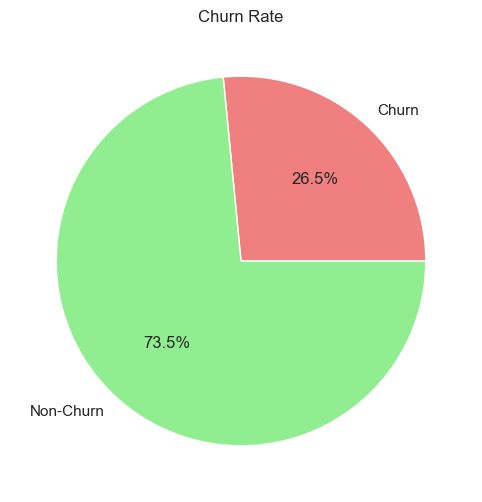

In [41]:
# Calculate the churn and non-churn counts
churn_count = df[df['Churn'] == 1].customerID.nunique()
non_churn_count = df[df['Churn'] == 0].customerID.nunique()

# Set up the plot size and title
plt.figure(figsize=(8, 6))
plt.title('Churn Rate')

# Set the colors for the pie chart sections
colors = ['lightcoral', 'lightgreen']

# Create the pie chart
plt.pie([churn_count, non_churn_count], labels=['Churn', 'Non-Churn'], autopct='%1.1f%%', colors=colors)

# Display the plot
plt.show()


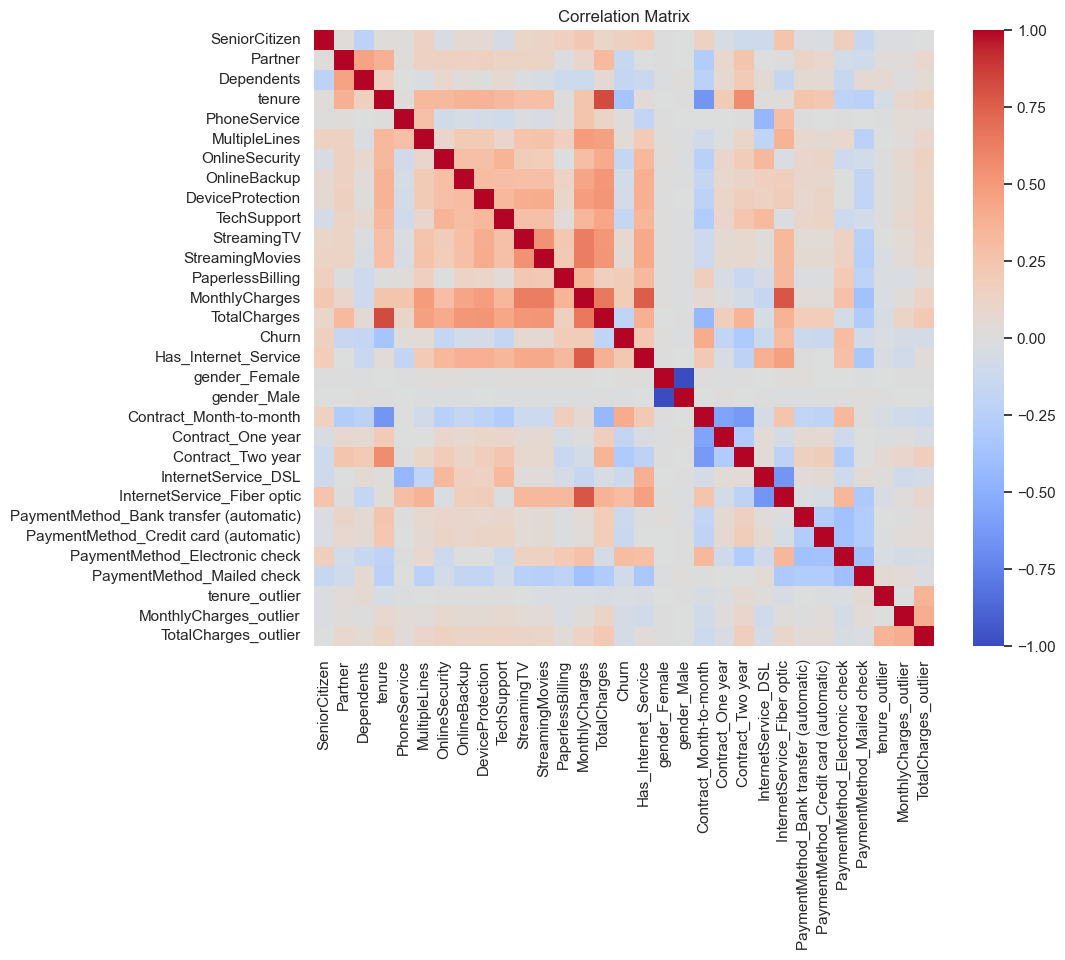

In [42]:
# Create a correlation matrix
corr_matrix = df.corr()

# Set up the plot size
sns.set(rc={'figure.figsize':(10,8)})

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')

# Display the plot
plt.show()


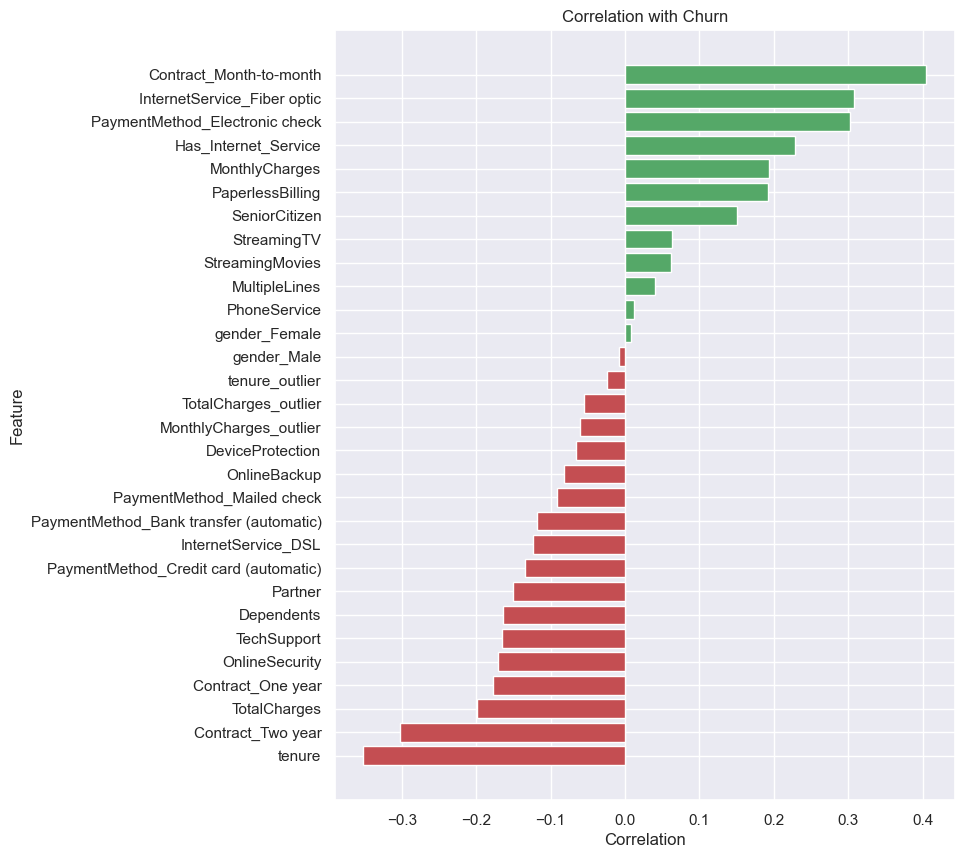

In [43]:
# Calculate pairwise correlation values between 'churn' column and all other columns
corr_churn = df.corr()['Churn']

# Load your correlation data into a pandas dataframe
corr_df = pd.DataFrame({'Feature': corr_churn.index, 'Correlation': corr_churn.values})

# Remove the 'Churn' feature from the dataframe
corr_df = corr_df[corr_df['Feature'] != 'Churn']

# Sort the dataframe by correlation values
sorted_corr_df = corr_df.sort_values(by='Correlation')

# Extract the feature names and correlation values as numpy arrays
features = sorted_corr_df['Feature'].values
corr_values = sorted_corr_df['Correlation'].values

# Assign colors to the bars based on their values
colors = np.where(corr_values > 0, 'g', 'r')

# Set the figure size
fig, ax = plt.subplots(figsize=(8, 10))

# Plot the horizontal bar chart
ax.barh(features, corr_values, color=colors)

# Add labels and title to the plot
ax.set_xlabel('Correlation')
ax.set_ylabel('Feature')
ax.set_title('Correlation with Churn')

plt.show()


The positive correlation of the "Contract_Month-to-month" feature with churn means that customers who are on a monthly contract are more likely to churn than customers who are on a longer-term contract. This could be because customers on monthly contracts have more flexibility to switch providers without penalties or fees, compared to those on longer-term contracts.

The negative correlation of "tenure" with churn means that the longer a customer has been with a provider, the less likely they are to churn. This could be because customers who have been with a provider for a longer period of time have become more loyal, or have built up a greater level of satisfaction with the service over time.

We can display the top correlation features in absolute values in order to have a more informative view.

In [44]:
# Create correlation between Churn and other features ordered
#  by absolute correlation descending 

# Load your correlation data into a pandas dataframe
corr_df = pd.DataFrame({'Feature': corr_churn.index, 'Correlation': corr_churn.values})

# Remove the 'Churn' feature from the dataframe
corr_df = corr_df[corr_df['Feature'] != 'Churn']

# Round correlation values
corr_df['Correlation'] = round(corr_df['Correlation'], 2)

# Add a new column with absolute correlation values
corr_df['Abs_Correlation'] = abs(corr_df['Correlation'])

# Sort the dataframe by absolute correlation values
sorted_corr_df = corr_df.sort_values(by='Abs_Correlation', ascending=False).reset_index(drop=True)

# Display the sorted dataframe
sorted_corr_df[['Feature', 'Correlation']].head(10)


,Feature,Correlation
0,Contract_Month-to-month,0.41
1,tenure,-0.35
2,InternetService_Fiber optic,0.31
3,PaymentMethod_Electronic check,0.30
4,Contract_Two year,-0.30
5,Has_Internet_Service,0.23
6,TotalCharges,-0.20
7,PaperlessBilling,0.19
8,MonthlyCharges,0.19
9,Contract_One year,-0.18


# Identifying different segments of customers
In this section we are analysing in a more detailed way the insights from the correlation matrix. This will help us understand better why some features are highly predictive and what we can expect from a combination of them. For example, are senior citizens more or less likely to churn? After how many charges are customers reducing their likelihood to churn?

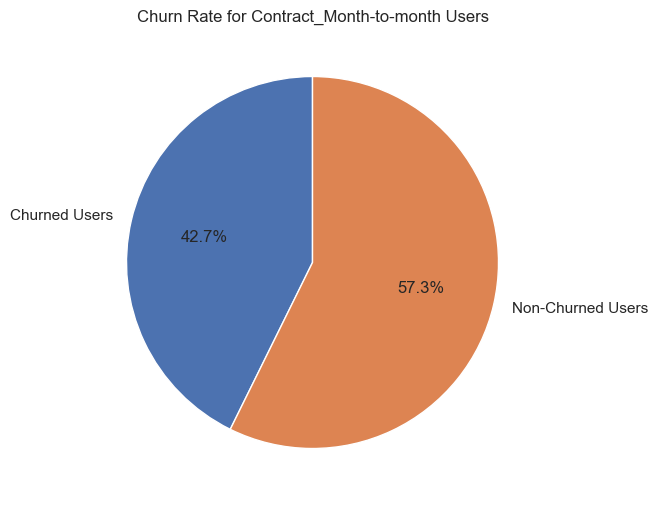

Users with monthly contracts are more likely to churn compared to all the popularion (26.5%)


In [45]:
# Calculate the total number of Contract_Month-to-month users
total_monthly = df[df['Contract_Month-to-month'] == 1].shape[0]

# Calculate the number of Contract_Month-to-month users who churned
churned_monthly = df[(df['Contract_Month-to-month'] == 1) & (df['Churn'] == 1)].shape[0]

# Calculate the churn rate for Contract_Month-to-month users
monthly_churn_rate = churned_monthly / total_monthly

# Create labels and sizes for pie chart
labels = ['Churned Users', 'Non-Churned Users']
sizes = [monthly_churn_rate, 1-monthly_churn_rate]

# Set the figure size
fig, ax = plt.subplots(figsize=(6, 8))

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Churn Rate for Contract_Month-to-month Users')

# Show the chart
plt.show()

print('Users with monthly contracts are more likely to churn compared to all the popularion (26.5%)')


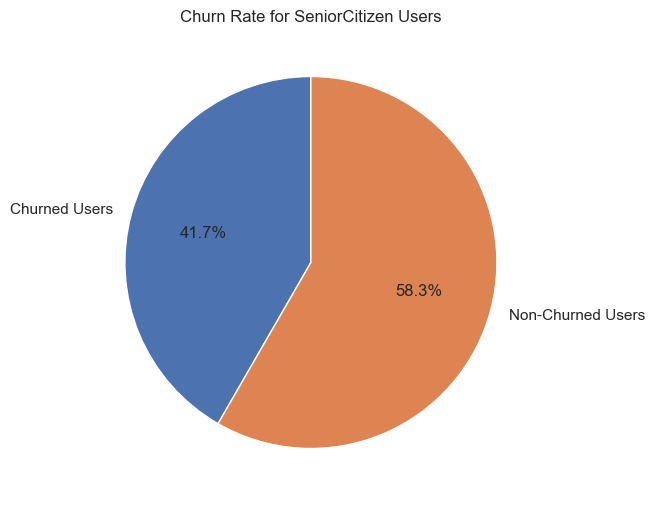

Seniors are more likely to churn compared to all the popularion (26.5%)


In [46]:

# Calculate the total number of SeniorCitizen users
total_seniors = df[df['SeniorCitizen'] == 1].shape[0]

# Calculate the number of SeniorCitizen users who churned
churned_seniors = df[(df['SeniorCitizen'] == 1) & (df['Churn'] == 1)].shape[0]

# Calculate the churn rate for SeniorCitizen users
senior_churn_rate = churned_seniors / total_seniors

# Create labels and sizes for pie chart
labels = ['Churned Users', 'Non-Churned Users']
sizes = [senior_churn_rate, 1-senior_churn_rate]

# Set the figure size
fig, ax = plt.subplots(figsize=(6, 8))

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Churn Rate for SeniorCitizen Users')

# Show the chart
plt.show()

print('Seniors are more likely to churn compared to all the popularion (26.5%)')


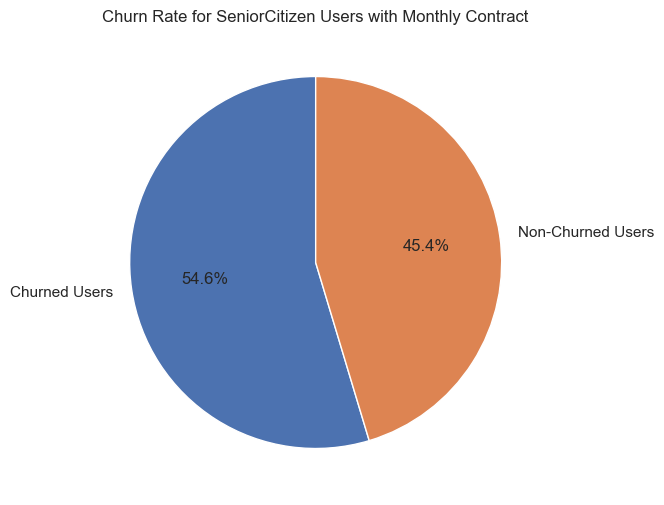

This segment is very likely to churn and should be monitored closely


In [47]:

# Filter the dataframe based on Contract_Month-to-month column
df_monthly = df[df['Contract_Month-to-month'] == 1]

# Calculate the total number of SeniorCitizen users with Monthly Contract
total_monthly_seniors = df_monthly[df_monthly['SeniorCitizen'] == 1].shape[0]

# Calculate the number of SeniorCitizen users with Monthly Contract who churned
churned_monthly_seniors = df_monthly[(df_monthly['SeniorCitizen'] == 1) & (df_monthly['Churn'] == 1)].shape[0]

# Calculate the churn rate for SeniorCitizen users with Monthly Contract
monthly_senior_churn_rate = churned_monthly_seniors / total_monthly_seniors

# Create labels and sizes for pie chart
labels = ['Churned Users', 'Non-Churned Users']
sizes = [monthly_senior_churn_rate, 1-monthly_senior_churn_rate]

# Set the figure size
fig, ax = plt.subplots(figsize=(6, 8))

# Create a pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Churn Rate for SeniorCitizen Users with Monthly Contract')

# Show the chart
plt.show()

print('This segment is very likely to churn and should be monitored closely')



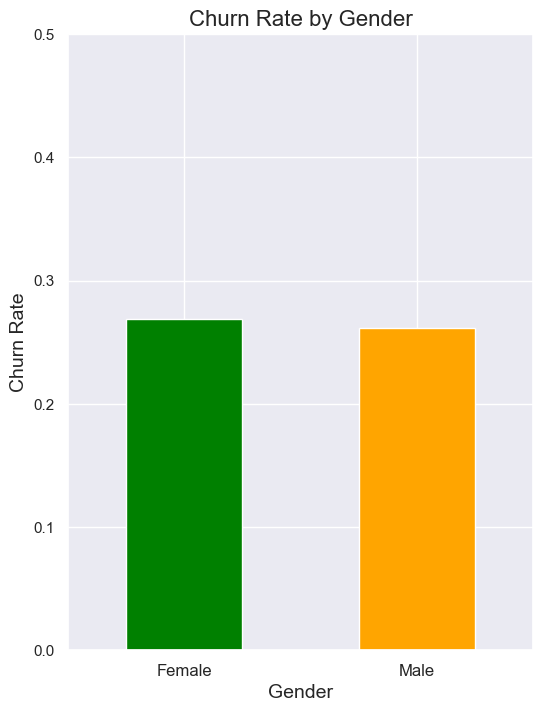

Gender does not impact heavily the probability to churn


In [48]:
# Calculate the total number of male and female users
total_users = df.groupby(['gender_Male', 'Churn']).size().unstack(fill_value=0).sum(axis=1)

# Calculate the number of male and female users who churned
churned_users = df.groupby(['gender_Male', 'Churn']).size().unstack(fill_value=0)[1]

# Calculate the churn rate for male and female users
churn_rate = churned_users / total_users

# Create a bar chart
ax = churn_rate.plot(kind='bar', figsize=(6, 8), color=['green', 'orange'], rot=0)

# Set the chart title and labels
ax.set_title('Churn Rate by Gender', fontsize=16)
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Churn Rate', fontsize=14)

# Set the x-axis tick labels
ax.set_xticklabels(['Female', 'Male'], fontsize=12)

# Set the y-axis limits
ax.set_ylim([0, 0.5])

# Show the chart
plt.show()

print('Gender does not impact heavily the probability to churn')


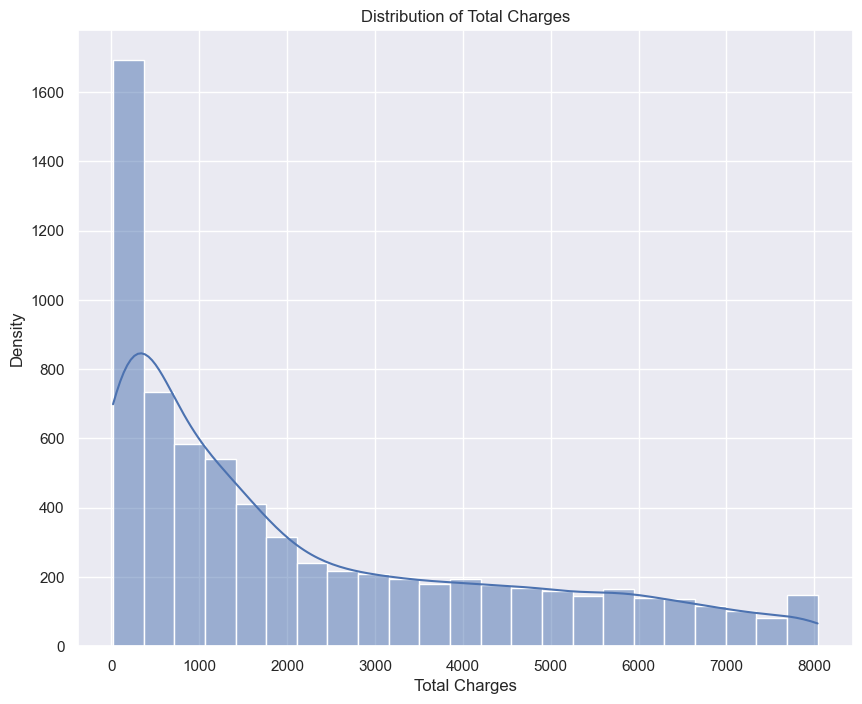

In [49]:
# Create distribution plot
sns.histplot(df['TotalCharges'], kde=True)

# Set chart title and axis labels
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Density')

# Show the chart
plt.show()

Average Total Charges: 2276.73


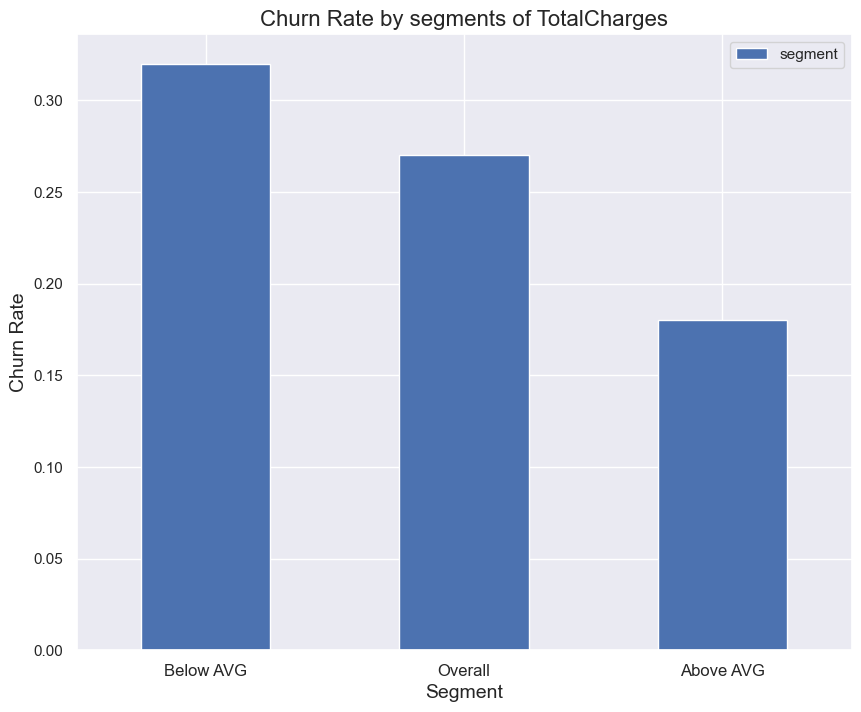

Users that have been charged less total amount over time, are more likely to churn


In [50]:
# Visualise what's the churn rate for users above and below TotalCharges average
print('Average Total Charges:', round(df['TotalCharges'].mean(),2))
plot_churn_below_above_avg(df, 'TotalCharges')

print('Users that have been charged less total amount over time, are more likely to churn')

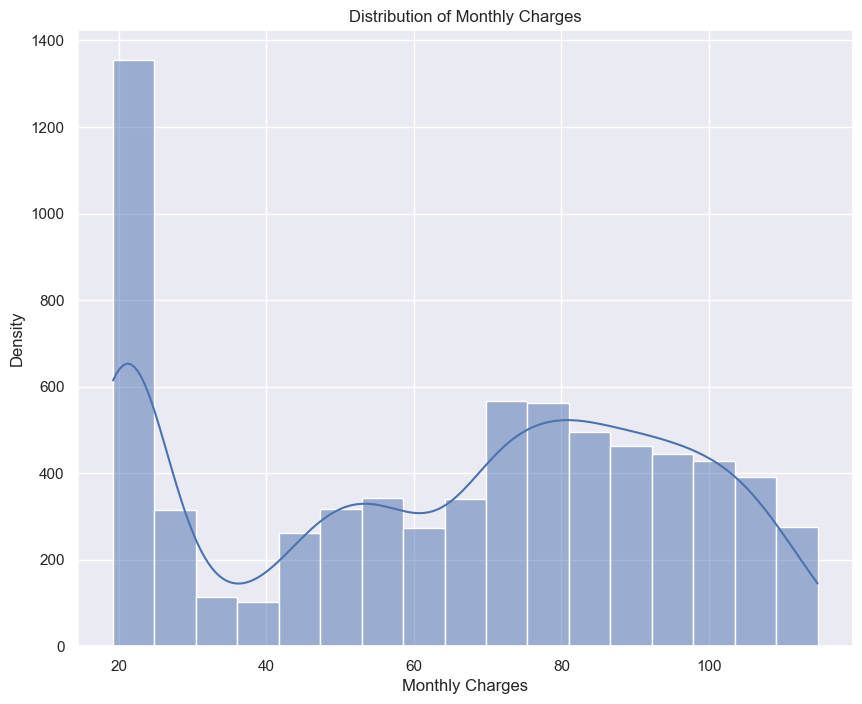

In [51]:
# Create distribution plot
sns.histplot(df['MonthlyCharges'], kde=True)

# Set chart title and axis labels
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Density')

# Show the chart
plt.show()

Average Monthly Charges: 64.75


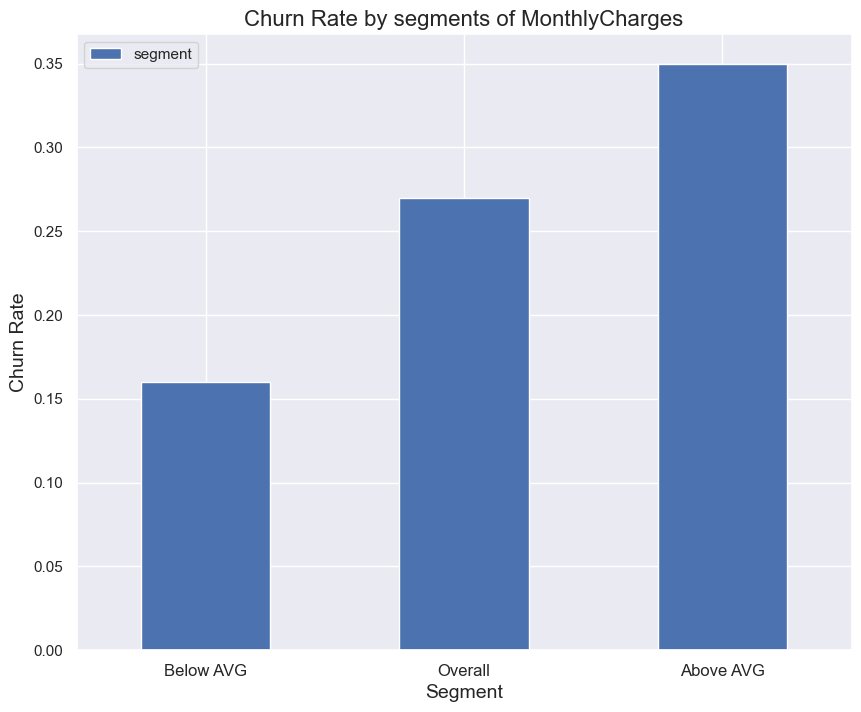

Users that have been charged a higher amount per month are more likely to churn. This indicates that customers are price sensitive and may be looking to more competitive offers from competitors


In [52]:
# Visualise what's the churn rate for users above and below MonthlyCharges average
print('Average Monthly Charges:', round(df['MonthlyCharges'].mean(),2))
plot_churn_below_above_avg(df, 'MonthlyCharges')

print('Users that have been charged a higher amount per month are more likely to churn. This indicates that customers are price sensitive and may be looking to more competitive offers from competitors')